DAtaseet link: https://drive.google.com/drive/folders/14vR5tYSWsYsgFdJVnyZC0jpUiRIW_fi6?usp=sharing

# Big Data Processing for Medical Image Diagnosis: A Deep Learning Approach with Apache Spark

# Content

1. Environment Setup: Importing necessary libraries and configuring Spark.
2. Data Loading: Loaded the CSV file and filtered the dataset.
3. Data Exploration  and Visualization.
3. Data Preprocessing: Converted the dataset to a Pandas DataFrame and extracted disease labels.
4. Unzipping and Loading Images
5. Loading and Preprocessing Image. Set up the transforms for every image:Resize to 224x224 (no needed), Convert to tensor, Normalize using ImageNet mean & std
6. Model Building (CNN)
7. Training the Model
8. Evaluating the Model

In [1]:
#Importing Necessary Libraries

#General Libraries
import numpy as np  # For numerical operations
import pandas as pd  # For handling dataframes
import os  # For file and directory operations
import shutil  # For file operations
import zipfile  # For extracting zip files
import matplotlib.pyplot as plt  # For plotting images
%matplotlib inline  # To display plots inside the notebook    

#PySpark Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

import warnings
warnings.filterwarnings('ignore')

UsageError: unrecognized arguments: # To display plots inside the notebook


In [2]:
#Create Spark Session
spark = SparkSession.builder \
    .appName("SparkSQL") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

#Load Dataset
csv_path = "file:///home/hduser/Downloads/CA1_Project/Data_Entry_2017.csv"
df = spark.read.csv(csv_path, header=True, inferSchema=True)

df.printSchema()
df.show(5)

25/03/30 16:30:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- Image Index: string (nullable = true)
 |-- Finding Labels: string (nullable = true)
 |-- Follow-up #: integer (nullable = true)
 |-- Patient ID: integer (nullable = true)
 |-- Patient Age: string (nullable = true)
 |-- Patient Gender: string (nullable = true)
 |-- View Position: string (nullable = true)
 |-- OriginalImage[Width: integer (nullable = true)
 |-- Height]: integer (nullable = true)
 |-- OriginalImagePixelSpacing[x: double (nullable = true)
 |-- y]: double (nullable = true)
 |-- _c11: string (nullable = true)



25/03/30 16:30:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Image Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Gender, View Position, OriginalImage[Width, Height], OriginalImagePixelSpacing[x, y], 
 Schema: Image Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Gender, View Position, OriginalImage[Width, Height], OriginalImagePixelSpacing[x, y], _c11
Expected: _c11 but found: 
CSV file: file:///home/hduser/Downloads/CA1_Project/Data_Entry_2017.csv


+----------------+--------------------+-----------+----------+-----------+--------------+-------------+-------------------+-------+---------------------------+-----+----+
|     Image Index|      Finding Labels|Follow-up #|Patient ID|Patient Age|Patient Gender|View Position|OriginalImage[Width|Height]|OriginalImagePixelSpacing[x|   y]|_c11|
+----------------+--------------------+-----------+----------+-----------+--------------+-------------+-------------------+-------+---------------------------+-----+----+
|00000001_000.png|        Cardiomegaly|          0|         1|       058Y|             M|           PA|               2682|   2749|                      0.143|0.143|null|
|00000001_001.png|Cardiomegaly|Emph...|          1|         1|       058Y|             M|           PA|               2894|   2729|                      0.143|0.143|null|
|00000001_002.png|Cardiomegaly|Effu...|          2|         1|       058Y|             M|           PA|               2500|   2048|              

In [3]:
#Checking the number of rows in the Dataset
row_count = df.count()

print(f"The dataset has {row_count} rows.")

The dataset has 112120 rows.


In [4]:
#Checking the column names
df.columns

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'OriginalImage[Width',
 'Height]',
 'OriginalImagePixelSpacing[x',
 'y]',
 '_c11']

#### I am using SQL-like operations with PySpark for data preprocessing and am filtering and selecting relevant data before converting to Pandas. PyTorch requires an indexable dataset, threfore I switch to Pandas before training. My dataset fits in memory after preprocessing, therefore there is not need to do distributed computing.

- NOTE: I could only upload images from "0000001_000.png" to "00012364_012.png" (1.10GB), therefore, I have to filter rows in that range. Due to technical issues, I had to upload the images manually instead of compressing them.

In [5]:
from pyspark.sql.functions import col  #Import col

#Filtering rows based on image index
df_filtered = df.filter(
    (col("`Image Index`") >= "00000001_000.png") & 
    (col("`Image Index`") <= "00012364_012.png")
)

#Extracting relevant information
df_filtered = df_filtered.select("`Image Index`", "`Finding Labels`")

#Converting to Pandas (switching to Pandas for deep learning because PyTorch's Dataset and DataLoader require an indexable dataset)
pandas_df = df_filtered.toPandas()

#Extracting disease labels as lists
pandas_df['Labels'] = pandas_df['Finding Labels'].str.split('|')

#Print and Check
print(pandas_df.head())

        Image Index          Finding Labels                     Labels
0  00000001_000.png            Cardiomegaly             [Cardiomegaly]
1  00000001_001.png  Cardiomegaly|Emphysema  [Cardiomegaly, Emphysema]
2  00000001_002.png   Cardiomegaly|Effusion   [Cardiomegaly, Effusion]
3  00000002_000.png              No Finding               [No Finding]
4  00000003_000.png                  Hernia                   [Hernia]


In [6]:
filtered_csv_path = "/home/hduser/Downloads/CA1_Project/Data_Entry_Filtered.csv"

pandas_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered CSV saved at: {filtered_csv_path}")

Filtered CSV saved at: /home/hduser/Downloads/CA1_Project/Data_Entry_Filtered.csv


In [7]:
print(df_filtered.head(10))

[Row(Image Index='00000001_000.png', Finding Labels='Cardiomegaly'), Row(Image Index='00000001_001.png', Finding Labels='Cardiomegaly|Emphysema'), Row(Image Index='00000001_002.png', Finding Labels='Cardiomegaly|Effusion'), Row(Image Index='00000002_000.png', Finding Labels='No Finding'), Row(Image Index='00000003_000.png', Finding Labels='Hernia'), Row(Image Index='00000003_001.png', Finding Labels='Hernia'), Row(Image Index='00000003_002.png', Finding Labels='Hernia'), Row(Image Index='00000003_003.png', Finding Labels='Hernia|Infiltration'), Row(Image Index='00000003_004.png', Finding Labels='Hernia'), Row(Image Index='00000003_005.png', Finding Labels='Hernia')]


In [8]:
print(df_filtered.columns)  

['Image Index', 'Finding Labels']


In [9]:
print(f"Number of rows: {df_filtered.count()}")

Number of rows: 48746


In [10]:
#Extracting unique disease labels
unique_labels = set([label for sublist in pandas_df['Labels'] for label in sublist])
print(f"Unique disease labels: {unique_labels}")

Unique disease labels: {'Edema', 'Cardiomegaly', 'Consolidation', 'Mass', 'Emphysema', 'No Finding', 'Pleural_Thickening', 'Effusion', 'Atelectasis', 'Pneumonia', 'Infiltration', 'Fibrosis', 'Nodule', 'Pneumothorax', 'Hernia'}


In [35]:
#Checking for missing values
print(pandas_df.isnull().sum())  

Image Index       0
Finding Labels    0
Labels            0
dtype: int64


### Unzipping and Loading Images

In [11]:
zip_path = "/home/hduser/Downloads/CA1_Project/Images.zip"
extracted_folder = "/home/hduser/Downloads/CA1_Project/Images/"

#Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [12]:
extracted_folder = "/home/hduser/Downloads/CA1_Project/Images/Images/"
image_dir = "/home/hduser/Downloads/CA1_Project/Images/Images/"

### Loading and Preprocessing Images
* Convert to tensor
* Normalize using ImageNet mean & std
* Image transformation (images are already 224x224)

In [13]:
#Importing Necessary Libraries - Torch and Deep Learning Libraries

#sudo apt install pip (Execute command on terminal)
#pip install torch torchvision torchaudio --break-system-packages (Execute command on terminal)

import torch  #Main PyTorch library
import torch.nn as nn  #For defining deep learning models
import torch.optim as optim  # For optimizers (e.g., Adam)
from torch.utils.data import Dataset, DataLoader  #For dataset management
from torchvision import transforms #For image transformations
import torchvision.transforms as transforms  
import torchvision.models as models  #Pre-trained models (ResNet)
from PIL import Image  #For image processing

In [14]:
#Definining the ChestXrayDataset Class to load images and labels

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx]["Image Index"])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]  #Disease label(s)
        
        if self.transform:
            image = self.transform(image)

        #one-hot encoded format (if needed)
        labels = self.one_hot_encode_labels(label)
        
        return image, labels
    
    def one_hot_encode_labels(self, labels):
        unique_labels = list(pandas_df['Labels'].explode().unique())
        one_hot = np.zeros(len(unique_labels))
        for label in labels.split('|'):
            one_hot[unique_labels.index(label)] = 1
        return one_hot

### Checking DataLoader

In [15]:
#Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  #Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

#DataLoaders will help to load the data in mini-batches, making the training process more efficient
from torch.utils.data import DataLoader

dataset = ChestXrayDataset(dataframe=pandas_df, image_dir=extracted_folder, transform=transform)

#Create a DataLoader for batching and shuffling
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset size: {len(dataset)}")

Dataset size: 48746


In [16]:
#Check one batch
for images, labels in data_loader:
    print(images.shape)  #Shape should be (batch_size, 3, 224, 224)
    print(labels.shape)  #Shape should be (batch_size, num_labels)
    break  #Only show one batch for testing

torch.Size([32, 3, 224, 224])
torch.Size([32, 15])


### Test Image Loading

Image Shape: torch.Size([3, 224, 224])
Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


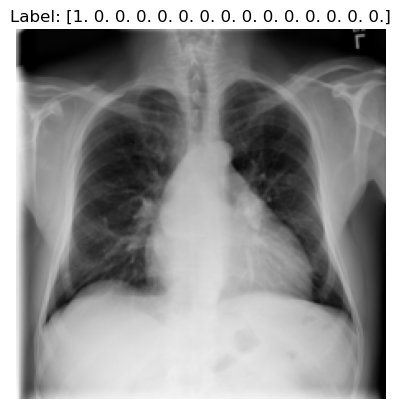

In [17]:
image, label = dataset[0]  

print(f"Image Shape: {image.shape}")  #Should be (3, 224, 224)
print(f"Label: {label}")

#Convert image tensor to numpy
image_np = image.numpy().transpose(1, 2, 0)  #Change shape to (H, W, C)

#Undo normalization for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean  #Denormalize
image_np = np.clip(image_np, 0, 1)  #Clip values

#Display image
plt.imshow(image_np)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

### Checking for missing or extra values from the csv file and the directory

In [18]:
csv_path = "/home/hduser/Downloads/CA1_Project/Data_Entry_Filtered.csv"
image_dir = "/home/hduser/Downloads/CA1_Project/Images/Images/"

df_filtered = pd.read_csv(csv_path)

csv_filenames = set(df_filtered["Image Index"])  

folder_filenames = set(os.listdir(image_dir))

#Find missing and extra files
missing_files = csv_filenames - folder_filenames  
extra_files = folder_filenames - csv_filenames  

print(f"Total images listed in CSV: {len(csv_filenames)}")
print(f"Total images found in folder: {len(folder_filenames)}")
print(f"Missing images: {len(missing_files)}")
print(f"Extra images: {len(extra_files)}")

if missing_files:
    print("\nMissing files (first 10 shown):")
    print(list(missing_files)[:10])

if extra_files:
    print("\nExtra files (first 10 shown):")
    print(list(extra_files)[:10])

Total images listed in CSV: 48746
Total images found in folder: 48747
Missing images: 0
Extra images: 1

Extra files (first 10 shown):
['Images']


In [19]:
print("Extra files:", extra_files)

Extra files: {'Images'}


In [20]:
#Getting list of only .png files in the directory
folder_filenames = {f for f in os.listdir(image_dir) if f.endswith('.png')}

#Compare again
missing_files = csv_filenames - folder_filenames
extra_files = folder_filenames - csv_filenames

In [21]:
if extra_files:
    for extra_file in extra_files:
        extra_path = os.path.join(image_dir, extra_file)
        if os.path.isfile(extra_path):  
            os.remove(extra_path)
            print(f"Deleted extra image: {extra_file}")

In [22]:
print(f"After cleanup - Images in CSV: {len(csv_filenames)}, Images in folder: {len(folder_filenames)}")

After cleanup - Images in CSV: 48746, Images in folder: 48746


# Model Building (CNN)

### Defining the Model

The chest X-ray classification problem is a multi-label classification task (one image can have multiple diseases).

Pre-trained ResNet18 is a proven approach for deep learning in medical imaging. It saves time, improves performance, and works well for small medical datasets.

Since the chest X-ray images can have multiple diseases, the best approach is treating each disease as a separate binary classification problem using nn.BCEWithLogitsLoss(). Therefore, the examples from class are not appropriate (Cross-Entropy, Sparse Cross-Entropy and KL Divergence).

Each output neuron corresponds to a single disease, and we apply sigmoid activation to get individual probabilities.

The loss function calculates binary cross-entropy (BCE) for each disease separately.

In [23]:
#Importing Necessary Libraries for Machine Learning & Evaluation

#sudo apt install python3-pip (Execute command on terminal)
#sudo pip3 install scikit-learn --break-system-packages (Execute command on terminal)

from sklearn.model_selection import train_test_split  # Splitting dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Model evaluation
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [24]:
#Setting Training Hyperparameters
batch_size = 32
num_epochs = 10  #increase for better performance
learning_rate = 0.001

In [25]:
#Split dataset (80% training, 20% testing)
train_df, test_df = train_test_split(pandas_df, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = ChestXrayDataset(dataframe=train_df, image_dir=extracted_folder, transform=transform)
test_dataset = ChestXrayDataset(dataframe=test_df, image_dir=extracted_folder, transform=transform)

#Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  #Training
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #Testing

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 38996
Testing dataset size: 9750


In [26]:
#Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

#Modify the final fully connected layer to match the number of labels
num_labels = len(pandas_df['Labels'].explode().unique())  #Count unique diseases
model.fc = nn.Linear(model.fc.in_features, num_labels)

#Moving model to GPU if available (deep learning works best with a GPU - faster)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  #Binary classification loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Model and training setup complete")

/home/hduser/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hduser/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model and training setup complete


#### Verify Data Loaders to confirm that the images are loaded correctly

In [27]:
#Get a batch of training data
images, labels = next(iter(train_loader))

print(f"Batch image shape: {images.shape}")  #Should be [batch_size, 3, 224, 224]
print(f"Batch label shape: {labels.shape}")  #Should be [batch_size, num_labels]

Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32, 15])


In [28]:
labels = labels.float()

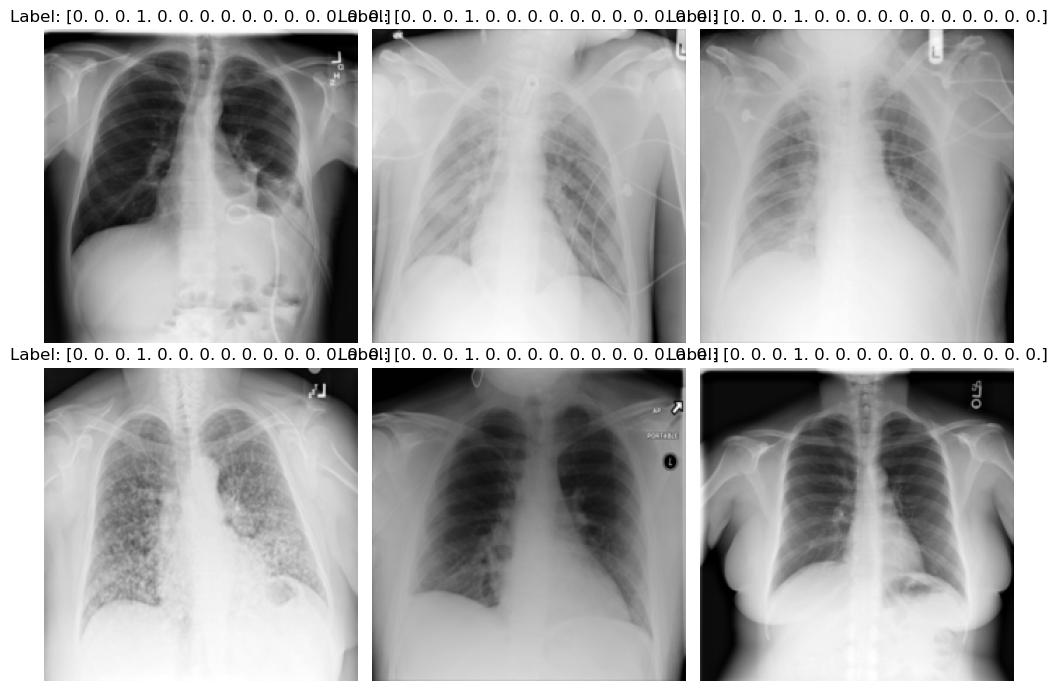

In [29]:
#Function to display images in grayscale
def imshow(img, label):
    img = img.detach().cpu().numpy().squeeze(0)  #Convert Tensor to NumPy and remove color channel
    plt.imshow(img, cmap="gray")  #Display in grayscale
    plt.title(f"Label: {label}")
    plt.axis('off')

#Display first 6 images in grayscale
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i, ax in enumerate(axes.flat):
    if i < len(images):  #Ensure we don't go out of bounds
        img = images[i].mean(dim=0)  #Convert RGB to grayscale by averaging channels
        lbl = labels[i].cpu().numpy()  #Move to CPU
        ax.imshow(img, cmap="gray")  #Use grayscale colormap
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')

plt.tight_layout()
plt.show()

### Training the Model

In [30]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [31]:
#Checking if the data loop is running, data loaders are not emppty and if the GPU is working
print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total training images: {len(train_dataset)}")

print(f"Using device: {device}")
print(torch.cuda.is_available())  #The VM does not have direct access to the host system’s GPU. GPU rrruns faster than CPU.

Total batches in train_loader: 4875
Total training images: 38996
Using device: cpu
False


In [37]:
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")
    break  #Check only one batch

Batch shape: torch.Size([8, 3, 224, 224]), Labels shape: torch.Size([8, 15])


In [32]:
images, labels = next(iter(train_loader))  #Get one batch
images, labels = images.to(device), labels.to(device)

outputs = model(images)
print("Outputs shape:", outputs.shape)
print("Labels shape:", labels.shape)

Outputs shape: torch.Size([8, 15])
Labels shape: torch.Size([8, 15])


In [38]:
#Defining the Training Function

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=5):
    model.train()  #Set model to training mode
    print("Training started...")

    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"Epoch {epoch+1}/{num_epochs} started")  

        for batch_idx, (images, labels) in enumerate(train_loader):
            print(f"Processing batch {batch_idx+1}/{len(train_loader)}")  

            images, labels = images.to(device), labels.to(device).float()  #Ensure labels are float for BCEWithLogitsLoss
            
            optimizer.zero_grad()  #Reset gradients
            outputs = model(images)  #Forward pass
            loss = criterion(outputs, labels)  #Compute loss

            if batch_idx % 100 == 0:  #Print loss every 100 batches
                print(f"Batch {batch_idx+1}, Loss: {loss.item():.4f}")

            loss.backward()  #Backpropagation
            optimizer.step()  #Update weights

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(train_loader):.4f}")

    print("Training complete!")

In [40]:
train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

Training started...
Epoch 1/5 started
Processing batch 1/4875
Batch 1, Loss: 0.1968
Processing batch 2/4875
Processing batch 3/4875
Processing batch 4/4875
Processing batch 5/4875
Processing batch 6/4875
Processing batch 7/4875
Processing batch 8/4875
Processing batch 9/4875
Processing batch 10/4875
Processing batch 11/4875
Processing batch 12/4875
Processing batch 13/4875
Processing batch 14/4875
Processing batch 15/4875
Processing batch 16/4875
Processing batch 17/4875
Processing batch 18/4875
Processing batch 19/4875
Processing batch 20/4875
Processing batch 21/4875
Processing batch 22/4875
Processing batch 23/4875
Processing batch 24/4875
Processing batch 25/4875
Processing batch 26/4875
Processing batch 27/4875
Processing batch 28/4875
Processing batch 29/4875
Processing batch 30/4875
Processing batch 31/4875
Processing batch 32/4875
Processing batch 33/4875
Processing batch 34/4875
Processing batch 35/4875
Processing batch 36/4875
Processing batch 37/4875
Processing batch 38/4875

Processing batch 316/4875
Processing batch 317/4875
Processing batch 318/4875
Processing batch 319/4875
Processing batch 320/4875
Processing batch 321/4875
Processing batch 322/4875
Processing batch 323/4875
Processing batch 324/4875
Processing batch 325/4875
Processing batch 326/4875
Processing batch 327/4875
Processing batch 328/4875
Processing batch 329/4875
Processing batch 330/4875
Processing batch 331/4875
Processing batch 332/4875
Processing batch 333/4875
Processing batch 334/4875
Processing batch 335/4875
Processing batch 336/4875
Processing batch 337/4875
Processing batch 338/4875
Processing batch 339/4875
Processing batch 340/4875
Processing batch 341/4875
Processing batch 342/4875
Processing batch 343/4875
Processing batch 344/4875
Processing batch 345/4875
Processing batch 346/4875
Processing batch 347/4875
Processing batch 348/4875
Processing batch 349/4875
Processing batch 350/4875
Processing batch 351/4875
Processing batch 352/4875
Processing batch 353/4875
Processing b

Processing batch 629/4875
Processing batch 630/4875
Processing batch 631/4875
Processing batch 632/4875
Processing batch 633/4875
Processing batch 634/4875
Processing batch 635/4875
Processing batch 636/4875
Processing batch 637/4875
Processing batch 638/4875
Processing batch 639/4875
Processing batch 640/4875
Processing batch 641/4875
Processing batch 642/4875
Processing batch 643/4875
Processing batch 644/4875
Processing batch 645/4875
Processing batch 646/4875
Processing batch 647/4875
Processing batch 648/4875
Processing batch 649/4875
Processing batch 650/4875
Processing batch 651/4875
Processing batch 652/4875
Processing batch 653/4875
Processing batch 654/4875
Processing batch 655/4875
Processing batch 656/4875
Processing batch 657/4875
Processing batch 658/4875
Processing batch 659/4875
Processing batch 660/4875
Processing batch 661/4875
Processing batch 662/4875
Processing batch 663/4875
Processing batch 664/4875
Processing batch 665/4875
Processing batch 666/4875
Processing b

Processing batch 942/4875
Processing batch 943/4875
Processing batch 944/4875
Processing batch 945/4875
Processing batch 946/4875
Processing batch 947/4875
Processing batch 948/4875
Processing batch 949/4875
Processing batch 950/4875
Processing batch 951/4875
Processing batch 952/4875
Processing batch 953/4875
Processing batch 954/4875
Processing batch 955/4875
Processing batch 956/4875
Processing batch 957/4875
Processing batch 958/4875
Processing batch 959/4875
Processing batch 960/4875
Processing batch 961/4875
Processing batch 962/4875
Processing batch 963/4875
Processing batch 964/4875
Processing batch 965/4875
Processing batch 966/4875
Processing batch 967/4875
Processing batch 968/4875
Processing batch 969/4875
Processing batch 970/4875
Processing batch 971/4875
Processing batch 972/4875
Processing batch 973/4875
Processing batch 974/4875
Processing batch 975/4875
Processing batch 976/4875
Processing batch 977/4875
Processing batch 978/4875
Processing batch 979/4875
Processing b

Processing batch 1245/4875
Processing batch 1246/4875
Processing batch 1247/4875
Processing batch 1248/4875
Processing batch 1249/4875
Processing batch 1250/4875
Processing batch 1251/4875
Processing batch 1252/4875
Processing batch 1253/4875
Processing batch 1254/4875
Processing batch 1255/4875
Processing batch 1256/4875
Processing batch 1257/4875
Processing batch 1258/4875
Processing batch 1259/4875
Processing batch 1260/4875
Processing batch 1261/4875
Processing batch 1262/4875
Processing batch 1263/4875
Processing batch 1264/4875
Processing batch 1265/4875
Processing batch 1266/4875
Processing batch 1267/4875
Processing batch 1268/4875
Processing batch 1269/4875
Processing batch 1270/4875
Processing batch 1271/4875
Processing batch 1272/4875
Processing batch 1273/4875
Processing batch 1274/4875
Processing batch 1275/4875
Processing batch 1276/4875
Processing batch 1277/4875
Processing batch 1278/4875
Processing batch 1279/4875
Processing batch 1280/4875
Processing batch 1281/4875
P

Processing batch 1546/4875
Processing batch 1547/4875
Processing batch 1548/4875
Processing batch 1549/4875
Processing batch 1550/4875
Processing batch 1551/4875
Processing batch 1552/4875
Processing batch 1553/4875
Processing batch 1554/4875
Processing batch 1555/4875
Processing batch 1556/4875
Processing batch 1557/4875
Processing batch 1558/4875
Processing batch 1559/4875
Processing batch 1560/4875
Processing batch 1561/4875
Processing batch 1562/4875
Processing batch 1563/4875
Processing batch 1564/4875
Processing batch 1565/4875
Processing batch 1566/4875
Processing batch 1567/4875
Processing batch 1568/4875
Processing batch 1569/4875
Processing batch 1570/4875
Processing batch 1571/4875
Processing batch 1572/4875
Processing batch 1573/4875
Processing batch 1574/4875
Processing batch 1575/4875
Processing batch 1576/4875
Processing batch 1577/4875
Processing batch 1578/4875
Processing batch 1579/4875
Processing batch 1580/4875
Processing batch 1581/4875
Processing batch 1582/4875
P

Processing batch 1847/4875
Processing batch 1848/4875
Processing batch 1849/4875
Processing batch 1850/4875
Processing batch 1851/4875
Processing batch 1852/4875
Processing batch 1853/4875
Processing batch 1854/4875
Processing batch 1855/4875
Processing batch 1856/4875
Processing batch 1857/4875
Processing batch 1858/4875
Processing batch 1859/4875
Processing batch 1860/4875
Processing batch 1861/4875
Processing batch 1862/4875
Processing batch 1863/4875
Processing batch 1864/4875
Processing batch 1865/4875
Processing batch 1866/4875
Processing batch 1867/4875
Processing batch 1868/4875
Processing batch 1869/4875
Processing batch 1870/4875
Processing batch 1871/4875
Processing batch 1872/4875
Processing batch 1873/4875
Processing batch 1874/4875
Processing batch 1875/4875
Processing batch 1876/4875
Processing batch 1877/4875
Processing batch 1878/4875
Processing batch 1879/4875
Processing batch 1880/4875
Processing batch 1881/4875
Processing batch 1882/4875
Processing batch 1883/4875
P

Processing batch 2148/4875
Processing batch 2149/4875
Processing batch 2150/4875
Processing batch 2151/4875
Processing batch 2152/4875
Processing batch 2153/4875
Processing batch 2154/4875
Processing batch 2155/4875
Processing batch 2156/4875
Processing batch 2157/4875
Processing batch 2158/4875
Processing batch 2159/4875
Processing batch 2160/4875
Processing batch 2161/4875
Processing batch 2162/4875
Processing batch 2163/4875
Processing batch 2164/4875
Processing batch 2165/4875
Processing batch 2166/4875
Processing batch 2167/4875
Processing batch 2168/4875
Processing batch 2169/4875
Processing batch 2170/4875
Processing batch 2171/4875
Processing batch 2172/4875
Processing batch 2173/4875
Processing batch 2174/4875
Processing batch 2175/4875
Processing batch 2176/4875
Processing batch 2177/4875
Processing batch 2178/4875
Processing batch 2179/4875
Processing batch 2180/4875
Processing batch 2181/4875
Processing batch 2182/4875
Processing batch 2183/4875
Processing batch 2184/4875
P

Processing batch 2449/4875
Processing batch 2450/4875
Processing batch 2451/4875
Processing batch 2452/4875
Processing batch 2453/4875
Processing batch 2454/4875
Processing batch 2455/4875
Processing batch 2456/4875
Processing batch 2457/4875
Processing batch 2458/4875
Processing batch 2459/4875
Processing batch 2460/4875
Processing batch 2461/4875
Processing batch 2462/4875
Processing batch 2463/4875
Processing batch 2464/4875
Processing batch 2465/4875
Processing batch 2466/4875
Processing batch 2467/4875
Processing batch 2468/4875
Processing batch 2469/4875
Processing batch 2470/4875
Processing batch 2471/4875
Processing batch 2472/4875
Processing batch 2473/4875
Processing batch 2474/4875
Processing batch 2475/4875
Processing batch 2476/4875
Processing batch 2477/4875
Processing batch 2478/4875
Processing batch 2479/4875
Processing batch 2480/4875
Processing batch 2481/4875
Processing batch 2482/4875
Processing batch 2483/4875
Processing batch 2484/4875
Processing batch 2485/4875
P

Processing batch 2750/4875
Processing batch 2751/4875
Processing batch 2752/4875
Processing batch 2753/4875
Processing batch 2754/4875
Processing batch 2755/4875
Processing batch 2756/4875
Processing batch 2757/4875
Processing batch 2758/4875
Processing batch 2759/4875
Processing batch 2760/4875
Processing batch 2761/4875
Processing batch 2762/4875
Processing batch 2763/4875
Processing batch 2764/4875
Processing batch 2765/4875
Processing batch 2766/4875
Processing batch 2767/4875
Processing batch 2768/4875
Processing batch 2769/4875
Processing batch 2770/4875
Processing batch 2771/4875
Processing batch 2772/4875
Processing batch 2773/4875
Processing batch 2774/4875
Processing batch 2775/4875
Processing batch 2776/4875
Processing batch 2777/4875
Processing batch 2778/4875
Processing batch 2779/4875
Processing batch 2780/4875
Processing batch 2781/4875
Processing batch 2782/4875
Processing batch 2783/4875
Processing batch 2784/4875
Processing batch 2785/4875
Processing batch 2786/4875
P

Processing batch 3051/4875
Processing batch 3052/4875
Processing batch 3053/4875
Processing batch 3054/4875
Processing batch 3055/4875
Processing batch 3056/4875
Processing batch 3057/4875
Processing batch 3058/4875
Processing batch 3059/4875
Processing batch 3060/4875
Processing batch 3061/4875
Processing batch 3062/4875
Processing batch 3063/4875
Processing batch 3064/4875
Processing batch 3065/4875
Processing batch 3066/4875
Processing batch 3067/4875
Processing batch 3068/4875
Processing batch 3069/4875


KeyboardInterrupt: 

### Evaluating the Model

1. Loss Calculation (for validation). BCEWithLogitsLoss, compute the average validation loss during testing.
2.  Accuracy Calculation (Threshold-based). Since this is multi-label classification, we use threshold-based accuracy (e.g., if sigmoid output > 0.5, it's predicted as positive).
3.   Classification Report (Precision, Recall, F1-Score). Use classification_report from scikit-learn to calculate Precision, Recall, and F1-score.
4. Confusion Matrix (Multi-Label). For each label, calculate a separate confusion matrix.

* test_loss = evaluate_loss(model, test_loader, criterion, device)
* test_accuracy = evaluate_accuracy(model, test_loader, device)
* generate_classification_report(model, test_loader, device, unique_labels)
* generate_confusion_matrices(model, test_loader, device, unique_labels)

### Model Saving & Loading

- Use torch.save(model.state_dict(), "model.pth").
- Load the model later for inference.

In [ ]:
def save_model(model, path="chest_xray_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path="chest_xray_model.pth"):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()  #Set to evaluation mode
    print(f"Model loaded from {path}")
    return model

### Sample Image Prediction Function

In [ ]:
def predict_single_image(model, image_path, transform, device, unique_labels):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  #Add batch dimension

    with torch.no_grad():
        output = model(image)
        preds = torch.sigmoid(output).cpu().numpy() > 0.5  #Convert logits to binary

    pred_labels = [unique_labels[i] for i, pred in enumerate(preds[0]) if pred]
    return pred_labels

#Example
image_path = "/path/to/sample/image.png"
pred_labels = predict_single_image(model, image_path, transform, device, unique_labels)
print(f"Predicted Labels: {pred_labels}")